# Face Generation

Igor Genuino - igor.margen@gmail.com

In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

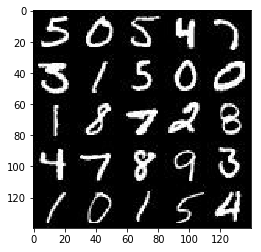

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

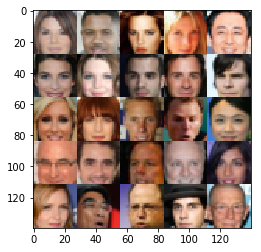

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, in_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, stddev=0.02):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    #Here I had some troubles to find a right way to pass the test.
    #I find the trick using stddev and alpha https://discussions.udacity.com/t/help-training-dont-improve-mnist-image-generation/468681
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 in: 28x28x(1|3)
        layer_1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 14x14x32
        
        # Layer 2: 14x14x32
        layer_2 = tf.layers.conv2d(layer_1, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 7x7x64
        
        layer_3 = tf.layers.conv2d(layer_2, 128, 5, 2, padding='same',  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 4x4x128
        
        layer_4 = tf.layers.conv2d(layer_3, 256, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 2x2x256
        
        flattened = tf.reshape(layer_4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits
        
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #Here I had some troubles to find a right way to pass the test.
    #I find the trick using stddev and alpha https://discussions.udacity.com/t/help-training-dont-improve-mnist-image-generation/468681
    
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1 in: 7x7x256
        layer_1 = tf.layers.dense(z, 4 * 4 * 512)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 4x4x512
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 128, 4, 1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 8x8x128
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 16x16x64
        
        layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 32x32x32
        
        logits = tf.layers.conv2d_transpose(layer_4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6154... Generator Loss: 2.4273
Epoch 1/2... Discriminator Loss: 0.8851... Generator Loss: 1.4347
Epoch 1/2... Discriminator Loss: 0.4234... Generator Loss: 2.5686
Epoch 1/2... Discriminator Loss: 0.6633... Generator Loss: 2.5551
Epoch 1/2... Discriminator Loss: 0.7360... Generator Loss: 1.7891
Epoch 1/2... Discriminator Loss: 0.4547... Generator Loss: 2.7238
Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 3.2140
Epoch 1/2... Discriminator Loss: 0.5564... Generator Loss: 1.7708
Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 1.1734
Epoch 1/2... Discriminator Loss: 0.8590... Generator Loss: 1.1910


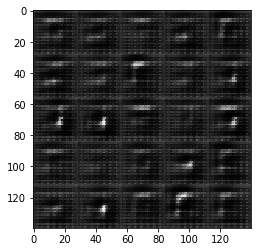

Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 1.1986
Epoch 1/2... Discriminator Loss: 0.8548... Generator Loss: 1.0540
Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 1.6036
Epoch 1/2... Discriminator Loss: 0.7855... Generator Loss: 1.5538
Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 3.0769
Epoch 1/2... Discriminator Loss: 0.4991... Generator Loss: 2.3365
Epoch 1/2... Discriminator Loss: 0.5683... Generator Loss: 2.3599
Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 1.6687
Epoch 1/2... Discriminator Loss: 0.7960... Generator Loss: 1.3456
Epoch 1/2... Discriminator Loss: 1.4945... Generator Loss: 0.4178


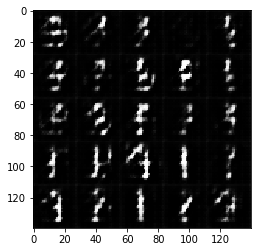

Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 0.8891
Epoch 1/2... Discriminator Loss: 0.7146... Generator Loss: 1.5399
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 1.2688
Epoch 1/2... Discriminator Loss: 1.3152... Generator Loss: 0.5528
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 0.6557
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 0.8540
Epoch 1/2... Discriminator Loss: 1.5932... Generator Loss: 0.4036
Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 1.1637


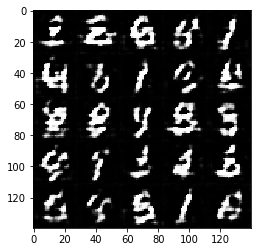

Epoch 1/2... Discriminator Loss: 1.4171... Generator Loss: 0.4826
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 0.7331
Epoch 1/2... Discriminator Loss: 1.6814... Generator Loss: 3.3862
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 1.2488
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 1.7316
Epoch 1/2... Discriminator Loss: 0.8494... Generator Loss: 1.5696
Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.2592
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 0.8539... Generator Loss: 1.4868
Epoch 1/2... Discriminator Loss: 1.1124... Generator Loss: 0.8599


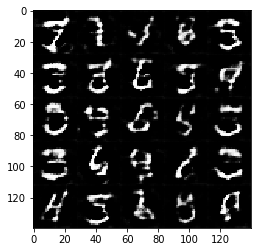

Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.5066
Epoch 1/2... Discriminator Loss: 1.4957... Generator Loss: 2.2239
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.1316
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 1.4711
Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 0.8448
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 0.7836
Epoch 1/2... Discriminator Loss: 1.6856... Generator Loss: 0.3414
Epoch 1/2... Discriminator Loss: 1.0334... Generator Loss: 0.8418
Epoch 1/2... Discriminator Loss: 1.2083... Generator Loss: 0.6707
Epoch 1/2... Discriminator Loss: 1.2456... Generator Loss: 0.6741


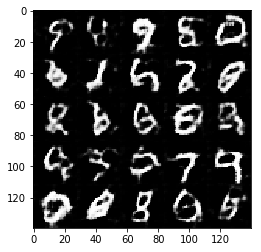

Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 1.1452
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 0.6323
Epoch 1/2... Discriminator Loss: 1.5284... Generator Loss: 0.6063
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 1.2665
Epoch 1/2... Discriminator Loss: 1.0722... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.7286
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 0.8122
Epoch 1/2... Discriminator Loss: 1.4340... Generator Loss: 0.7387
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.5332
Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 1.8027


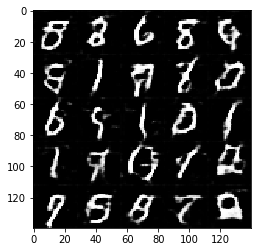

Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 1.2000
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 0.5784
Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 1.3632
Epoch 1/2... Discriminator Loss: 1.5917... Generator Loss: 0.4483
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 1.4145
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 0.5408
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 2.1979
Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 1.6074
Epoch 1/2... Discriminator Loss: 1.0106... Generator Loss: 1.1002


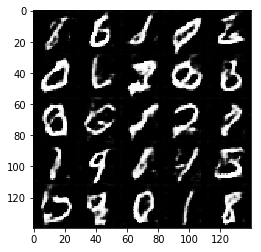

Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 1.1092
Epoch 1/2... Discriminator Loss: 1.0489... Generator Loss: 0.8077
Epoch 1/2... Discriminator Loss: 0.9419... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.5503
Epoch 1/2... Discriminator Loss: 1.2958... Generator Loss: 2.5833
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 0.9325... Generator Loss: 1.5973
Epoch 1/2... Discriminator Loss: 1.5390... Generator Loss: 0.4061
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.0057
Epoch 1/2... Discriminator Loss: 1.5531... Generator Loss: 0.4005


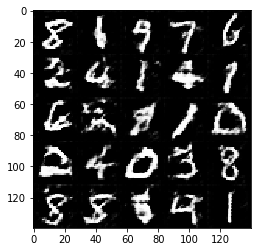

Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.6288
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 0.5213
Epoch 1/2... Discriminator Loss: 1.4718... Generator Loss: 0.4889
Epoch 1/2... Discriminator Loss: 1.6818... Generator Loss: 0.3926
Epoch 1/2... Discriminator Loss: 1.6415... Generator Loss: 1.8893
Epoch 1/2... Discriminator Loss: 0.8984... Generator Loss: 1.2886
Epoch 1/2... Discriminator Loss: 0.9436... Generator Loss: 1.4757
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.5084
Epoch 1/2... Discriminator Loss: 2.1489... Generator Loss: 3.1762
Epoch 1/2... Discriminator Loss: 1.2083... Generator Loss: 0.9284


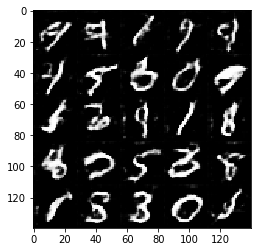

Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 0.9708
Epoch 1/2... Discriminator Loss: 1.0002... Generator Loss: 0.9594
Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 1.2641
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 2.4477
Epoch 2/2... Discriminator Loss: 2.0128... Generator Loss: 0.2201
Epoch 2/2... Discriminator Loss: 1.6723... Generator Loss: 0.3515
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 1.4413
Epoch 2/2... Discriminator Loss: 1.4112... Generator Loss: 0.4546
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.5553
Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.4885


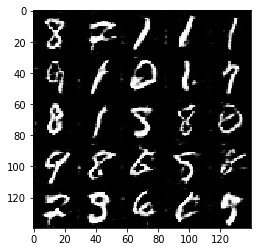

Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 1.3479
Epoch 2/2... Discriminator Loss: 1.4078... Generator Loss: 0.4613
Epoch 2/2... Discriminator Loss: 1.2991... Generator Loss: 0.7136
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.5557
Epoch 2/2... Discriminator Loss: 1.6225... Generator Loss: 0.3593
Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 1.4335
Epoch 2/2... Discriminator Loss: 2.0062... Generator Loss: 0.2525
Epoch 2/2... Discriminator Loss: 1.0740... Generator Loss: 0.9193
Epoch 2/2... Discriminator Loss: 1.3197... Generator Loss: 0.5383
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 1.1270


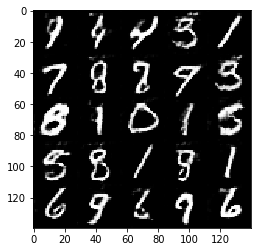

Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 1.1486
Epoch 2/2... Discriminator Loss: 1.7946... Generator Loss: 0.3184
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.6112
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.5337
Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 0.5630
Epoch 2/2... Discriminator Loss: 1.7342... Generator Loss: 0.3272
Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 0.6471
Epoch 2/2... Discriminator Loss: 1.3571... Generator Loss: 0.5274
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 0.9666
Epoch 2/2... Discriminator Loss: 1.2436... Generator Loss: 0.6904


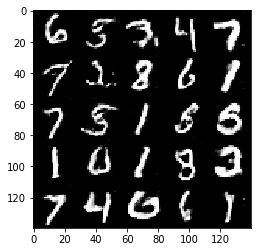

Epoch 2/2... Discriminator Loss: 1.5861... Generator Loss: 0.3761
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.6402
Epoch 2/2... Discriminator Loss: 1.4017... Generator Loss: 0.5821
Epoch 2/2... Discriminator Loss: 1.4277... Generator Loss: 0.4692
Epoch 2/2... Discriminator Loss: 1.9673... Generator Loss: 0.2900
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 0.6492
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 0.9846
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.9340
Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.7110
Epoch 2/2... Discriminator Loss: 1.6708... Generator Loss: 0.3430


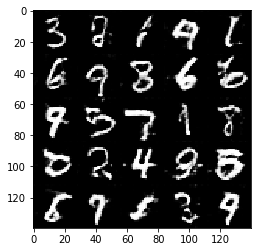

Epoch 2/2... Discriminator Loss: 1.6363... Generator Loss: 0.4296
Epoch 2/2... Discriminator Loss: 1.5099... Generator Loss: 0.4421
Epoch 2/2... Discriminator Loss: 1.2381... Generator Loss: 0.5977
Epoch 2/2... Discriminator Loss: 1.0237... Generator Loss: 1.4136
Epoch 2/2... Discriminator Loss: 1.4925... Generator Loss: 0.4369
Epoch 2/2... Discriminator Loss: 1.4540... Generator Loss: 0.4565
Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 1.0430
Epoch 2/2... Discriminator Loss: 1.2502... Generator Loss: 0.5640
Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.4397
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.5336


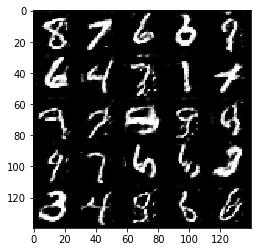

Epoch 2/2... Discriminator Loss: 1.3934... Generator Loss: 1.4671
Epoch 2/2... Discriminator Loss: 1.0392... Generator Loss: 1.1720
Epoch 2/2... Discriminator Loss: 1.4546... Generator Loss: 0.4850
Epoch 2/2... Discriminator Loss: 1.6316... Generator Loss: 0.3577
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 0.7653
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 1.5765
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.2411
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 1.3251
Epoch 2/2... Discriminator Loss: 1.7291... Generator Loss: 0.3102
Epoch 2/2... Discriminator Loss: 1.5533... Generator Loss: 0.4058


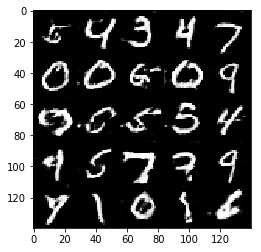

Epoch 2/2... Discriminator Loss: 1.5056... Generator Loss: 0.4457
Epoch 2/2... Discriminator Loss: 1.7907... Generator Loss: 0.2876
Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 1.1195
Epoch 2/2... Discriminator Loss: 1.0868... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 1.2205... Generator Loss: 0.7122
Epoch 2/2... Discriminator Loss: 1.4160... Generator Loss: 0.4707
Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 1.1654
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 0.8102
Epoch 2/2... Discriminator Loss: 1.0402... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 1.5213


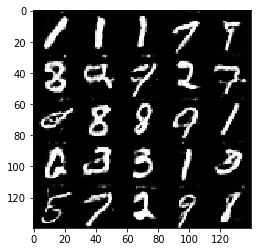

Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 1.0843
Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 2.0744
Epoch 2/2... Discriminator Loss: 2.1418... Generator Loss: 0.2053
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 1.2856
Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.8122
Epoch 2/2... Discriminator Loss: 1.7533... Generator Loss: 0.3603
Epoch 2/2... Discriminator Loss: 1.7112... Generator Loss: 0.3344
Epoch 2/2... Discriminator Loss: 1.1414... Generator Loss: 1.0793
Epoch 2/2... Discriminator Loss: 2.8553... Generator Loss: 0.1098
Epoch 2/2... Discriminator Loss: 1.0618... Generator Loss: 0.7611


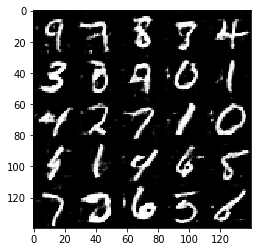

Epoch 2/2... Discriminator Loss: 1.1155... Generator Loss: 0.8697
Epoch 2/2... Discriminator Loss: 1.5724... Generator Loss: 0.4093
Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 0.6101
Epoch 2/2... Discriminator Loss: 4.6950... Generator Loss: 5.5922
Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 0.6891
Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 0.8398
Epoch 2/2... Discriminator Loss: 0.9197... Generator Loss: 1.1650
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 1.1384
Epoch 2/2... Discriminator Loss: 1.6040... Generator Loss: 0.3686
Epoch 2/2... Discriminator Loss: 1.2120... Generator Loss: 0.7558


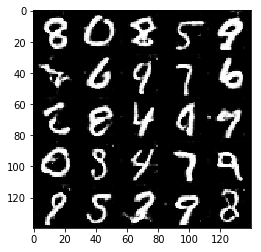

Epoch 2/2... Discriminator Loss: 1.3661... Generator Loss: 0.4971
Epoch 2/2... Discriminator Loss: 2.4643... Generator Loss: 0.1579
Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 1.0166
Epoch 2/2... Discriminator Loss: 0.7474... Generator Loss: 2.0552
Epoch 2/2... Discriminator Loss: 1.1577... Generator Loss: 0.7486
Epoch 2/2... Discriminator Loss: 1.1961... Generator Loss: 1.6999
Epoch 2/2... Discriminator Loss: 1.7126... Generator Loss: 0.3386


In [12]:
batch_size = 64 
z_dim = 128
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.1742
Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 1.5730
Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 1.9152
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.6004
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 1.9188
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 2.3682
Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 2.5697
Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 2.5666


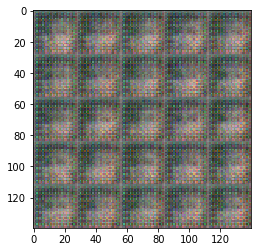

Epoch 1/1... Discriminator Loss: 0.5944... Generator Loss: 1.9301
Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 1.7042
Epoch 1/1... Discriminator Loss: 0.4633... Generator Loss: 2.6637
Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 2.1903
Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 2.5408
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.5953
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 2.5677
Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.7879


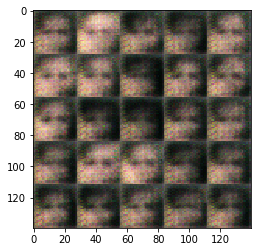

Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.6337
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.5415
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.2933
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.7524
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 1.7701
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 1.4875


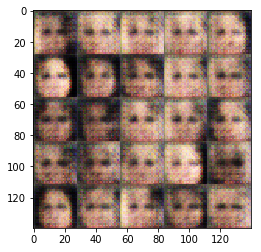

Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.2656
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.7516
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 1.5520
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 1.9850
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.2704
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.8345
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 2.1456
Epoch 1/1... Discriminator Loss: 0.5916... Generator Loss: 2.2558
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 2.1610


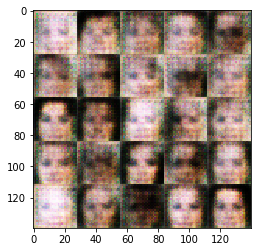

Epoch 1/1... Discriminator Loss: 0.5675... Generator Loss: 2.0616
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.5005
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.4964
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 1.5088
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 2.0200
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 0.7705... Generator Loss: 1.8751
Epoch 1/1... Discriminator Loss: 0.7600... Generator Loss: 1.5333


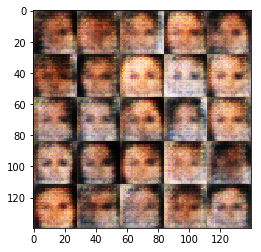

Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 1.7888
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.7244
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 1.0813
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.2461
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 1.5713
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.6857
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.3408
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.4106


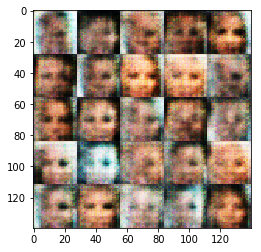

Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 1.5403
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 1.8935
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.6943
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 1.7858
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.0204


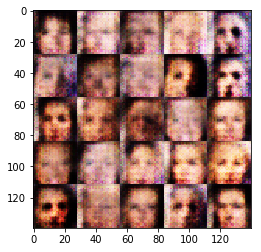

Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.4633
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.2581
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.0916
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.8986
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.0930


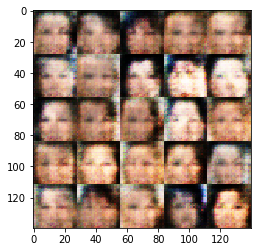

Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.2834
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.7264
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.0944


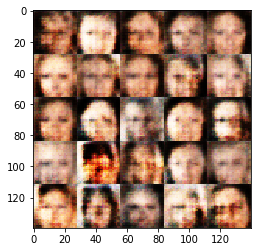

Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 1.2982
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 1.2847
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 1.2706
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 1.2300
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8992


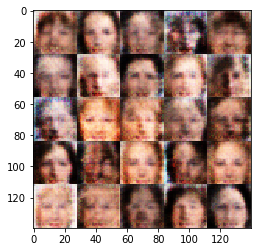

Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.2276
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 1.5015
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.9520


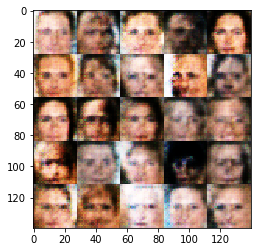

Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.0507
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.2227
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 1.2741
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.1142


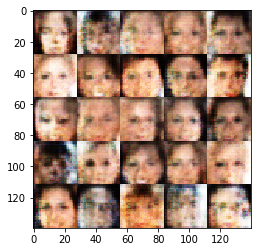

Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.1156
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.1545
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.0444


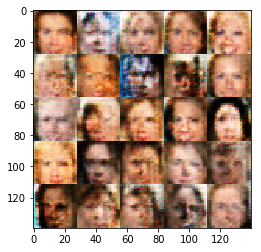

Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.1916
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 1.0206


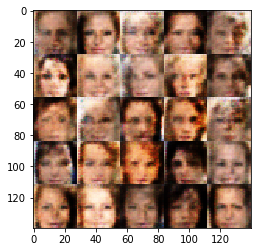

Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.3159
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 1.2973
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.3295
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.9241


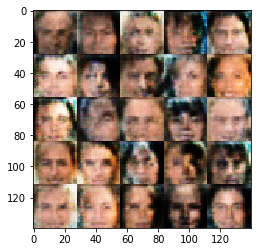

Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.3897
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.4116
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.2312


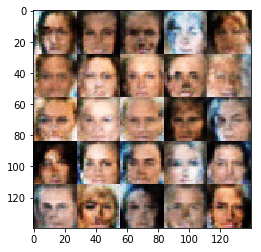

Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.4813
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.2827
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.4238
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 1.1793


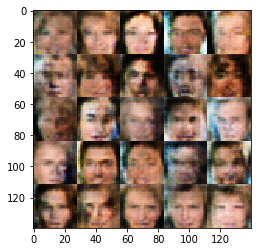

Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.6484
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 1.4214
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.9798


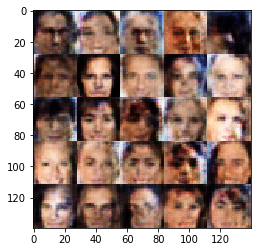

Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.3082
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.5022
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 1.3008
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.3594
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.2625


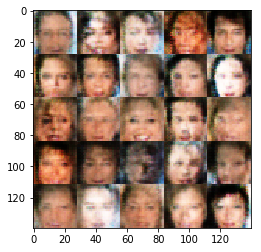

Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 1.2953
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.2661
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.0063


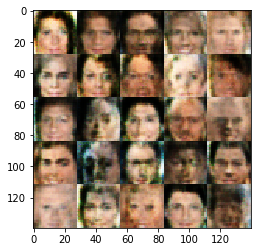

Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 1.2806
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 1.1938
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 1.4260
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.9108


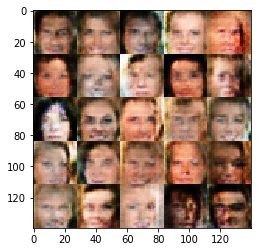

Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.1740
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.3320


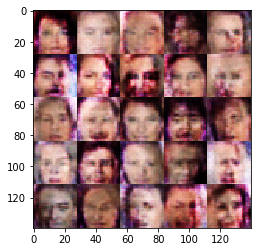

Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.5526
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.2380
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.7556


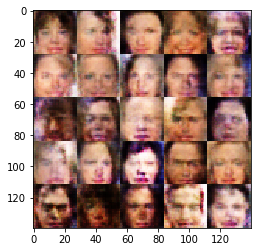

Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.4433


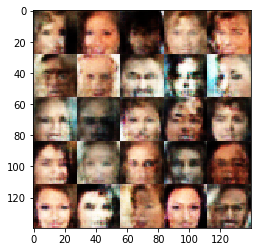

Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.4098
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 1.2093


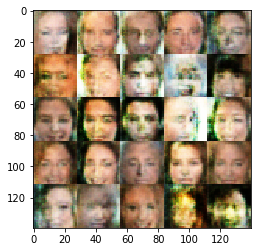

Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.6461


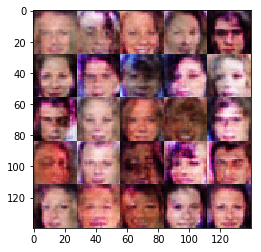

Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.1512
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.3171
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.9842


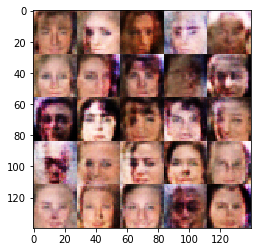

Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.4397
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.0998
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.8986


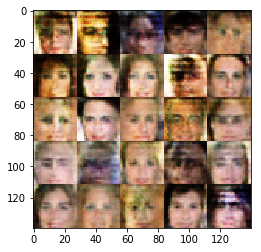

Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.3773
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.2169
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 1.0045


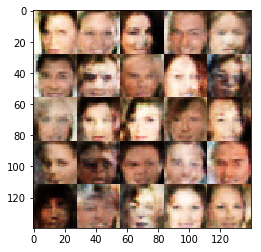

Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.2958
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.2687


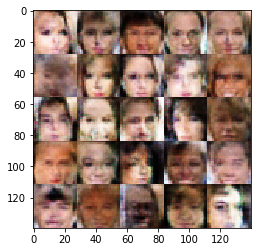

Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.3491
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.2594
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 1.1317
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.0094


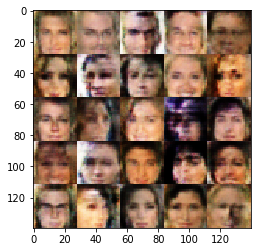

Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.9507


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.00008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.